# Imports

In [1]:
#Imports - general
import random
random.seed(15)
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')
from math import ceil, sqrt
import sklearn

%matplotlib inline

#Imports - RDKit
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect #, GetMorganFingerprint
#from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Chem.rdMolDescriptors import *

#Imports - additional
from os import listdir #for getting a list of files in a dir:
import time # for real-time timing the progress of the network

# Some global variables

In [2]:
path = 'data/targets/'   #path to .ism files

batch_number = 0
#Get the list of filenames in data/targets/ :
with open("receptors_desc.txt", "r") as f:
    receptors = [l.strip().split() for l in f.readlines()]

---

# Functions

## Preparing the dataset

In [3]:
''' Parse an .ism file, returning a list of smiles of molecules '''
def read_ism(file_name):
    result = []
    with open(file_name, 'r') as f:
        frl = f.readlines()
    for line in frl:
        line = line.split(	) # the arrow equals to '\t'
        mol = line[0]
        result.append(mol)
    return result

#### Creating molecule representations

In [4]:
''' For each molecule in the array (list of lists):
        create a binary vector showing which classes it belongs to
        and its representation for training (fingerprint or descriptor)'''
def get_class_vectors(lol_mols, rType):
    cv_dict = {}
    for i,l in enumerate(lol_mols):
        for mol in l:
            if mol not in cv_dict:
                
                smile = MolFromSmiles(mol)
                if rType == 'fingerprint':
                    rep = fingerprint(smile)
                elif rType == 'descriptor':
                    rep = descriptor(smile)
                else:
                    rep = fingerprint(smile) + descriptor(smile)
                
                x = [0]*len(lol_mols)
                cv_dict[mol] = [rep, x]
            cv_dict[mol][1][i] = 1
    return cv_dict

def fingerprint(smile):
    return GetMorganFingerprintAsBitVect(smile,2,1024)

def descriptor(smile):
    descriptors = []
    descriptors.append(CalcExactMolWt(smile))
    descriptors.append(CalcNumHBA(smile))
    descriptors.append(CalcNumHBD(smile))
    descriptors.append(CalcNumRotatableBonds(smile))
    descriptors.append(CalcTPSA(smile))
    descriptors.append(CalcFractionCSP3(smile))
    descriptors.append(CalcHallKierAlpha(smile))
    descriptors.append(CalcLabuteASA(smile))
    descriptors.append(CalcChi0n(smile))
    descriptors.append(CalcKappa1(smile))
    descriptors.append(CalcKappa3(smile))
    #descriptors.append(CalcNumHBA(smile))
    #descriptors.append(CalcNumHBD(smile))
    return descriptors

In [5]:
''' Create training and validation sets with labels from an array of smiles, shuffling the data '''
# lol_mols = "list of lists of molecules"
# mol_l = "list of molecules" <- how about class_i ?
def prepare_sets(lol_mols, val_prc=0.25, rType='fingerprint'):
    
    class_count = len(lol_mols)
    lengths = [len(mol_l) for mol_l in lol_mols]
    starts = [int(l*val_prc) for l in lengths] #start of training sets, end of validation sets
    
    # Create a representation and a class vector for each molecule
    molecules = get_class_vectors(lol_mols,rType)
    
    # Create the validation set:
    #     a list of representations (mols) and
    #     a list of corresponding class vectors (labels)
    val_mols, val_labels = [],[]
    
    for mol_l in lol_mols: # shuffle molecules in each class so that selection for validation is random
        random.shuffle(mol_l)
    
    for i in range(class_count):
        for j in range(starts[i]):
            mol = lol_mols[i][j]
            val_mols.append(molecules[mol][0])
            val_labels.append(molecules[mol][1])
    
    # Shuffle the remaining data and create the training set
    molecules_training = []
    for i,l in enumerate(lol_mols):
        molecules_training += l[starts[i]:]
    
    random.shuffle(molecules_training)
    train_set = [[],[]]
    
    for mol in molecules_training:
        train_set[0].append(molecules[mol][0])
        train_set[1].append(molecules[mol][1])
    
    return train_set, val_mols, val_labels

## Neuron layers

In [6]:
''' Create a single neuron layer - weight, bias, placeholder '''
def neuron_layer(isize, hsize, prev_placeholder):
    # weights and biases
    w = tf.Variable(tf.random_normal((isize, hsize), stddev=1/sqrt(isize)))
    b = tf.Variable(tf.random_normal((hsize,), stddev=0.1))
    # neuron
    h = tf.nn.sigmoid(tf.matmul(prev_placeholder, w) + b)
    return w,b,h

''' Create placeholders, weights and biases for all requested layers '''
def setup_layers(layers, osize, isize=1024):
    x = tf.placeholder(tf.float32, shape=[None,isize])
    active_layers = {'x':x,'w':[],'b':[],'h':[]}
    
    for i in range(len(layers)):
        if i == 0:
            w,b,h = neuron_layer(isize, layers[i], x)
        else:
            w,b,h = neuron_layer(layers[i-1], layers[i], prev_h)
        active_layers['w'].append(w)
        active_layers['b'].append(b)
        active_layers['h'].append(h)
        prev_h = h
    
    # Output Layer
    wo = tf.Variable(tf.random_normal((layers[-1], osize), stddev=1/sqrt(layers[-1])))
    bo = tf.Variable(tf.random_normal((osize,), stddev=0.1))
    a = tf.matmul(h, wo) + bo #h is the one last initialized in the loop > of the last layer
    
    # Placeholder for targets
    t = tf.placeholder(tf.float32, shape=[None, osize])
    
    active_layers['out'] = [wo,bo,a,t]
    return active_layers

## Training functions

In [7]:
''' Extract the next batch from a dataset '''
def next_batch(data, size): #data = [[fingerprints], [labels]]
        global batch_number
        batch_number = batch_number%((len(data[0]))//size)
        start = batch_number*size
        batch_number += 1
        return data[0][start:start+size], data[1][start:start+size]

''' Functions to compare network predictions with truth '''
# Returns the mean of correct predictions - all classes must be correctly predicted
def compare_pred(labels,predictions):
    #assert len(labels) == len(predictions), "Arrays of true and predicted values are not of equal length"
    result = []
    for i in range(len(labels)):
        result.append(labels[i] == predictions[i])
    return np.mean(result)

# Here each correct prediction of each class is calculated; should yield a higher score than the above
def compare_v2(labels,predictions):
    result = []
    for i in range(len(labels)):
        res_tmp = []
        for j in range(len(labels[i])):
            res_tmp.append(labels[i][j]==predictions[i][j])
        result.append(np.mean(res_tmp))
    return np.mean(result)

''' For timing the training of the network '''
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:05.2f}".format(int(minutes),seconds)

In [8]:
''' This function trains the network, returning the rate of training and validation accuracy '''
def train_network(data, batch_size, epochs):
    
    # Variables:
    start = time.time()
    iterations = ceil(len(data[1]) * epochs / batch_size)
    print(iterations, ' iterations')
    tr_rate = []
    val_rate = []
    ax_val_labels = val_labels
    batch_number = 0
    
    # Training:
    with tf.Session() as session:
        session.run(tf.initialize_all_variables())

        saver.save(session, "tmp/checkpoint", global_step=0)
        
        # Train the network
        for i in range(iterations):
            fps, labels = next_batch(data, batch_size)
            session.run(train, feed_dict={x: fps, t: labels})
            
            # Show progress and make a checkpoint
            if i%(iterations//10) == 0:
                progress = int((i/(iterations//10))*10)
                now = timer(start,time.time())
                print("%3i" % progress + '%, ' + str(now))
                saver.save(session, "tmp/checkpoint", global_step = 1000+progress)
            
            # Check predictions
            if i % 200 == 0:
                
                tr_target = labels
                tr_predictions = session.run(predict, feed_dict={x: fps, t: labels})
                tr_rate.append(compare_pred(tr_target,tr_predictions))

                val_predictions = session.run(predict, feed_dict={x: val_mols, t: val_labels})
                val_rate.append(compare_pred(ax_val_labels,val_predictions))
        
        # Final checkpoint
        saver.save(session, "tmp/checkpoint", global_step=2000)
    return tr_rate, val_rate

---

# Script

### Prepare data

In [9]:
num_class = 15
mol_matrix = []
for line in receptors[:num_class]:
    name = line[0]
    mol_list = read_ism(path + name)
    mol_matrix.append(mol_list)

In [29]:
# Type of representation:
rType = 'descriptor' # 'fingerprint'

%time train_set,val_mols,val_labels = prepare_sets(mol_matrix, 0.2, rType)

CPU times: user 43.6 s, sys: 0 ns, total: 43.6 s
Wall time: 43.3 s


### Create the network

In [11]:
#User-defined network variables:
layers = [20, 50, 30]
learning_rate = 0.0001
batch_size = 15
epochs = 5

### Train the network

In [12]:
%%time
# Automatic network variables
isize = len(val_mols[0])
osize = num_class

active_layers = setup_layers(layers, osize, isize)
x = active_layers['x'] # first placeholder
a = active_layers['out'][2] # output layer activations
t = active_layers['out'][3] # placeholder for targets

saver = tf.train.Saver(max_to_keep=14)

# Objective
'''Adam Optimizer'''
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(a, t)) # wypisywać do interpretacji w porównaniu do "głupich" sieci
train = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# Prediction
predict = tf.round(tf.nn.sigmoid(a)) # wektor binarny

# Train the network
tr_rate, val_rate = train_network(train_set, batch_size, epochs)

16238  iterations
  0%, 00:00.88
 10%, 00:03.66
 20%, 00:06.35
 30%, 00:08.88
 40%, 00:11.54
 50%, 00:14.07
 60%, 00:16.68
 70%, 00:19.36
 80%, 00:21.99
 90%, 00:24.75
100%, 00:27.38
CPU times: user 38.7 s, sys: 1.73 s, total: 40.4 s
Wall time: 28.3 s


### Plot prediction accuracy

Classes: 15, val_rate: 0.8735, Layers: [20, 50, 30], rType: descriptor
lr_rate: 0.0001, batch_size: 15, epochs: 5


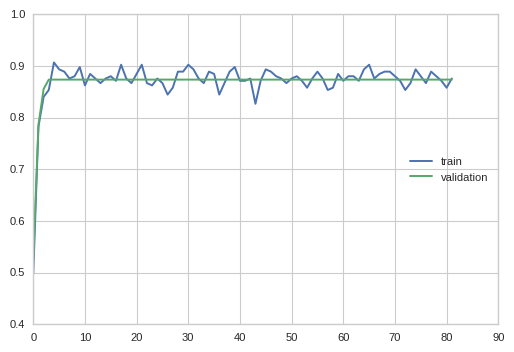

In [28]:
plt.plot(tr_rate, label='train')
plt.plot(val_rate, label='validation')
plt.legend(loc=5)
#print(max(val_rate), layers, learning_rate)
print("Classes: {:2}, val_rate: {:.4}, Layers: {}, rType: {}\nlr_rate: {}, batch_size: {}, epochs: {}".format(
        osize, max(val_rate), layers, rType, learning_rate, batch_size, epochs))

---

# Analysis

### Analyze first layer weights

In [14]:
checkpoints = [c for c in sorted(listdir('tmp')) if c[-1]=='0']

weights = []
with tf.Session() as sess:
    for ckpt in checkpoints:
        saver.restore(sess, 'tmp/'+ckpt)
        layer_1 = sess.run(active_layers['w'][0])
        weights.append(layer_1)

weights = np.array(weights)
w_first = weights[0]
w_last = weights[-1]
weights.shape

(13, 11, 20)

In [21]:
for i in range(len(w_last)):
    print("{:2}:{:8.3}   {:.3}".format(
        i+1, sum(w_last[i]-w_first[i]), sum(np.absolute(w_last[i]-w_first[i]))
        ))


 1: 0.00281   0.122
 2:  -0.103   0.265
 3:  -0.225   0.313
 4:   0.311   0.589
 5:    -0.1   0.245
 6:   0.212   0.553
 7:   0.181   0.456
 8: -0.0477   0.179
 9: -0.0758   0.196
10:  0.0314   0.08
11:   0.324   0.598


In [18]:
c = 3               # <-- column to analyse
print(np.where(w_last[c]-w_first[c] > 0.1))
print(np.where(w_last[c]-w_first[c] < -0.1))

(array([ 1,  4, 15]),)
(array([16]),)


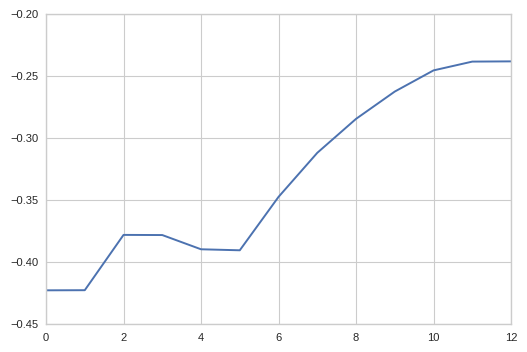

In [20]:
plt.plot(weights[:, c, 4])

{'boxes': [<matplotlib.lines.Line2D object at 0x7f924c41a2e8>, <matplotlib.lines.Line2D object at 0x7f924c427828>, <matplotlib.lines.Line2D object at 0x7f924c437320>, <matplotlib.lines.Line2D object at 0x7f924c442dd8>, <matplotlib.lines.Line2D object at 0x7f924c4538d0>, <matplotlib.lines.Line2D object at 0x7f924c0a33c8>, <matplotlib.lines.Line2D object at 0x7f924c0ac4a8>, <matplotlib.lines.Line2D object at 0x7f924c0baf60>, <matplotlib.lines.Line2D object at 0x7f924c0caa58>, <matplotlib.lines.Line2D object at 0x7f924c05a550>, <matplotlib.lines.Line2D object at 0x7f924c06a048>], 'whiskers': [<matplotlib.lines.Line2D object at 0x7f924c41acc0>, <matplotlib.lines.Line2D object at 0x7f924c41ae80>, <matplotlib.lines.Line2D object at 0x7f924c42b7b8>, <matplotlib.lines.Line2D object at 0x7f924c42bef0>, <matplotlib.lines.Line2D object at 0x7f924c437be0>, <matplotlib.lines.Line2D object at 0x7f924c43bb00>, <matplotlib.lines.Line2D object at 0x7f924c447d68>, <matplotlib.lines.Line2D object at 0x7f

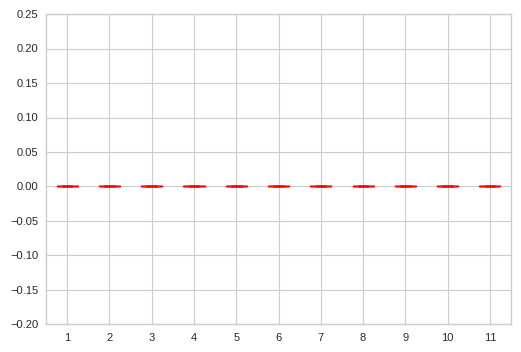

In [22]:
print(plt.boxplot(np.transpose(w_last-w_first)))

(array([ 1.,  3.,  1.,  1.,  1.,  3.,  5.,  2.,  1.,  2.]),
 array([-0.48617068, -0.4032292 , -0.32028772, -0.23734624, -0.15440477,
        -0.07146329,  0.01147819,  0.09441967,  0.17736115,  0.26030263,
         0.34324411]),
 <a list of 10 Patch objects>)

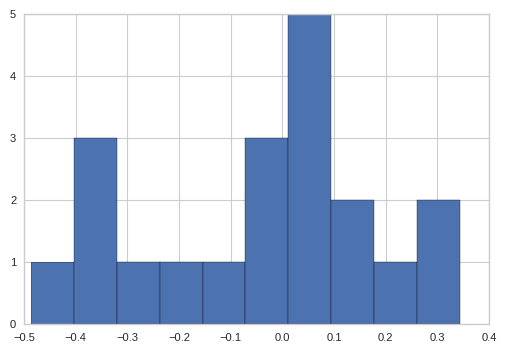

In [24]:
plt.hist(w_last[c])

---

# Previous learning results

Classes: 15, val_rate: 0.873170063554679, Layers: [100, 50, 30]
lr_rate: 0.0001, batch_size: 25, epochs: 5, vType: descriptor


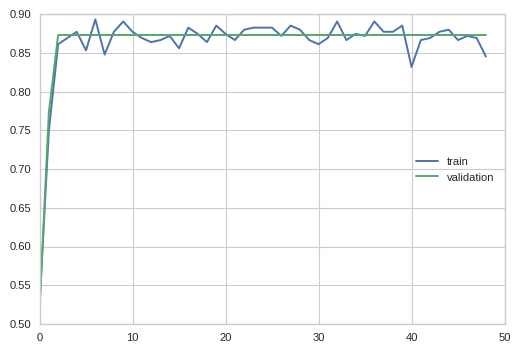

In [58]:
plt.plot(tr_rate, label='train')
plt.plot(val_rate, label='validation')
plt.legend(loc=5)
#print(max(val_rate), layers, learning_rate)
print("Classes: {}, val_rate: {}, Layers: {}\nlr_rate: {}, batch_size: {}, epochs: {}, vType: {}".format(
        osize, max(val_rate), layers, learning_rate, batch_size, epochs, vType))

Classes: 15, val_rate: 0.8945649791803638, Layers: [100, 50, 30], lr_rate: 0.001, vType: descriptor


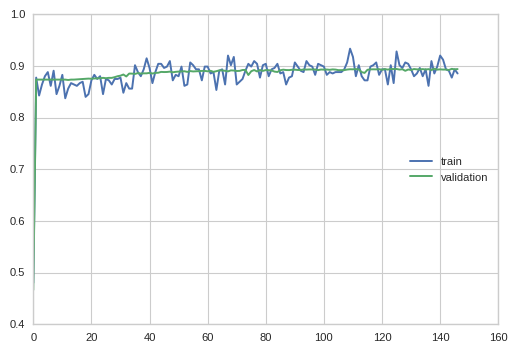

In [14]:
plt.plot(tr_rate, label='train')
plt.plot(val_rate, label='validation')
plt.legend(loc=5)
#print(max(val_rate), layers, learning_rate)
print("Classes: {}, val_rate: {}, Layers: {}, lr_rate: {}, vType: {}".format(
        osize, max(val_rate), layers, learning_rate, vType))

Classes: 15, val_rate: 0.8898586456278764, Layers: [30, 50, 30], lr_rate: 0.001, vType: descriptor


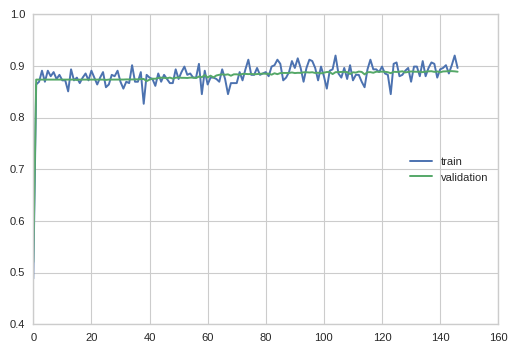

In [12]:
plt.plot(tr_rate, label='train')
plt.plot(val_rate, label='validation')
plt.legend(loc=5)
#print(max(val_rate), layers, learning_rate)
print("Classes: {}, val_rate: {}, Layers: {}, lr_rate: {}, vType: {}".format(
        osize, max(val_rate), layers, learning_rate, vType))

Classes: 15, val_rate: 0.9808459346920886, Layers: [500, 200, 500], lr_rate: 0.01, vType: fingerprint


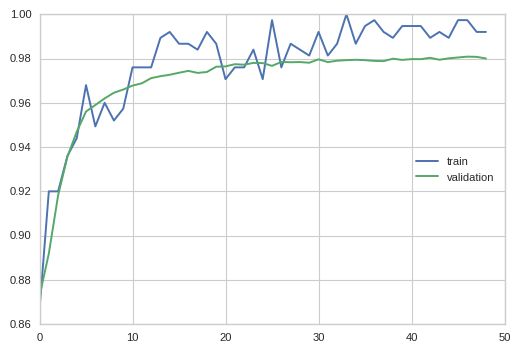

In [55]:
plt.plot(tr_rate, label='train')
plt.plot(val_rate, label='validation')
plt.legend(loc=5)
#print(max(val_rate), layers, learning_rate)
print("Classes: {}, val_rate: {}, Layers: {}, lr_rate: {}, vType: {}".format(
        osize, max(val_rate), layers, learning_rate, vType))

Classes: 15, val_rate: 0.9846756519833443, Layers: [500, 200, 500], lr_rate: 0.001, vType: fingerprint


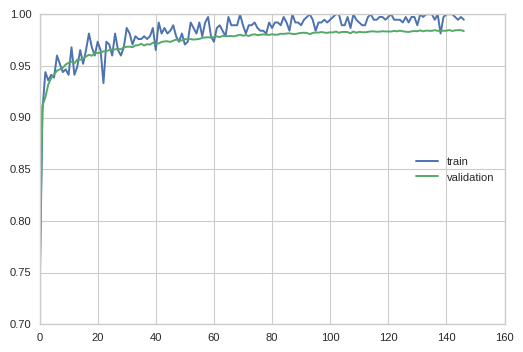

In [14]:
# 15 epochs
plt.plot(tr_rate, label='train')
plt.plot(val_rate, label='validation')
plt.legend(loc=5)
#print(max(val_rate), layers, learning_rate)
print("Classes: {}, val_rate: {}, Layers: {}, lr_rate: {}, vType: {}".format(
        osize, max(val_rate), layers, learning_rate, vType))